# LSTM for Time Series Prediction

This notebook illustrutes the time series prediction using a Long Short-Term Memory (LSTM) model implemented from scratch. 

The dataset used to train and evaluate the LSTM model is the **preprocessed** [TLC Trip Record dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The LSTM model aims to predict the future taxi demands given taxi demand time series at a certain pickup location.

## Imports

In [337]:
import numpy as np
import pylab as plt
import jax
import jax.numpy as jnp
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [357]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport model.lstm
%aimport model.helper

from model.lstm import Lstm
from model.helper import mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Processing

After downloading the raw data from the dataset, the [data processing notebook](/Taxi_data_processing.ipynb) is used to parse, analyse data and generate taxi pickup counts (demands) in the most popular pickup locations. Please refer to the report for more detailed data preprocessing information.

The following functions load, normalize the preprocessed data and output the training, validation, testing sets as algorithm input.

In [339]:
def generate_time_series_data(df, n_timesteps):
    X_train, Y_train = [], []
    for i in range(0, df.shape[0]):
        if i + 2 * n_timesteps < df.shape[0]:
            X = df[i: i + n_timesteps]
            # Y = df[i + n_timesteps: i + 2 * n_timesteps]
            Y = df[i + n_timesteps]
            X_train.append(X)
            Y_train.append(Y)
    X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
    return X_train, Y_train


def processing_data(location=237, n_timesteps=50, train_val_ratio=0.8):
    # load preprocessed data
    df_train, df_test = pd.read_csv(f'data/parsed/train_data{location}.csv'), pd.read_csv(f'data/parsed/test_data{location}.csv')
    df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])
    df_test['tpep_pickup_datetime'] = pd.to_datetime(df_test['tpep_pickup_datetime'])
    train_dates, test_dates = df_train['tpep_pickup_datetime'].to_numpy(), df_test['tpep_pickup_datetime'].to_numpy()
    df_train.drop(columns=['tpep_pickup_datetime', 'PULocationID'], inplace=True)
    df_test.drop(columns=['tpep_pickup_datetime', 'PULocationID'], inplace=True)
    
    # normalized data
    df_train =(df_train - df_train.mean()) / df_train.std()
    df_test =(df_test - df_test.mean()) / df_test.std()
    df_train, df_test = df_train.to_numpy(), df_test.to_numpy()

    # split train, validation, test set
    X, Y = generate_time_series_data(df_train, n_timesteps)
    X_test, Y_test = generate_time_series_data(df_test, n_timesteps)
    split_index = int(X.shape[0] * train_val_ratio)
    X_train, Y_train, X_val, Y_val = X[:split_index], Y[:split_index], X[split_index:], Y[split_index:]

    return train_dates, test_dates, X_train, Y_train, X_val, Y_val, X_test, Y_test  

## Model Training

The following cell initializes and runs the LSTM model on the processed datasets for the 3 pickup locations. One LSTM model is trained on each dataset (i.e. for each taxi pickup location).

In [340]:
n_timesteps = 50
num_features = 1
input_dim, hidden_dim, output_dim = num_features + 4, 4, 1
num_epoches = 200
learning_rate = 0.05
batch_size = 64

train_dates, test_dates, X_trains, Y_trains, X_vals, Y_vals, X_tests, Y_tests = [], [], [], [], [], [], [], []
Y_test_preds = []
for i, location in enumerate(['237', '161', '236']):
    print(f'------------------------- Location {location} -------------------------')
    train_date, test_date, X_train, Y_train, X_val, Y_val, X_test, Y_test = processing_data(location)
    print(f'Data: # training = {X_train.shape[0]} | # validation = {X_val.shape[0]} | # testing = {X_test.shape[0]}')
    train_dates.append(train_date)
    test_dates.append(test_date)
    X_trains.append(X_train)
    Y_trains.append(Y_train)
    X_vals.append(X_val)
    Y_vals.append(Y_val)
    X_tests.append(X_test)
    Y_tests.append(Y_test)
    model = Lstm(input_dim, hidden_dim, output_dim, num_epoches, learning_rate, batch_size)
    model.train(X_trains[i], Y_trains[i], X_vals[i], Y_vals[i])
    Y_test_pred = model.predict(X_tests[i])
    Y_test_preds.append(Y_test_pred)

------------------------- Location 237 -------------------------
Data: # training = 21560 | # validation = 5391 | # testing = 6663
Start training ...
Epoch 1/200: training loss = 0.14195437729358673 | validation loss = 0.081700399518013
Epoch 11/200: training loss = 0.06006184220314026 | validation loss = 0.0703655555844307
Epoch 21/200: training loss = 0.05917469784617424 | validation loss = 0.06925050169229507
Epoch 31/200: training loss = 0.05877700448036194 | validation loss = 0.06872472167015076
Epoch 41/200: training loss = 0.05841903015971184 | validation loss = 0.06828972697257996
Epoch 51/200: training loss = 0.057996995747089386 | validation loss = 0.06782141327857971
Epoch 61/200: training loss = 0.05734919384121895 | validation loss = 0.06713473051786423
Epoch 71/200: training loss = 0.05590606853365898 | validation loss = 0.06557814031839371
Epoch 81/200: training loss = 0.05175982043147087 | validation loss = 0.061408139765262604
Epoch 91/200: training loss = 0.0496103540

## Evaluation: MSE + Line Plot

- **Quantitative measure**: MSE
- **Qualitative measure**: line plot of true and predicted taxi pickups across time

Model prediction MSE = 0.05633772537112236
Model prediction MSE = 0.061036162078380585
Model prediction MSE = 0.05685260146856308


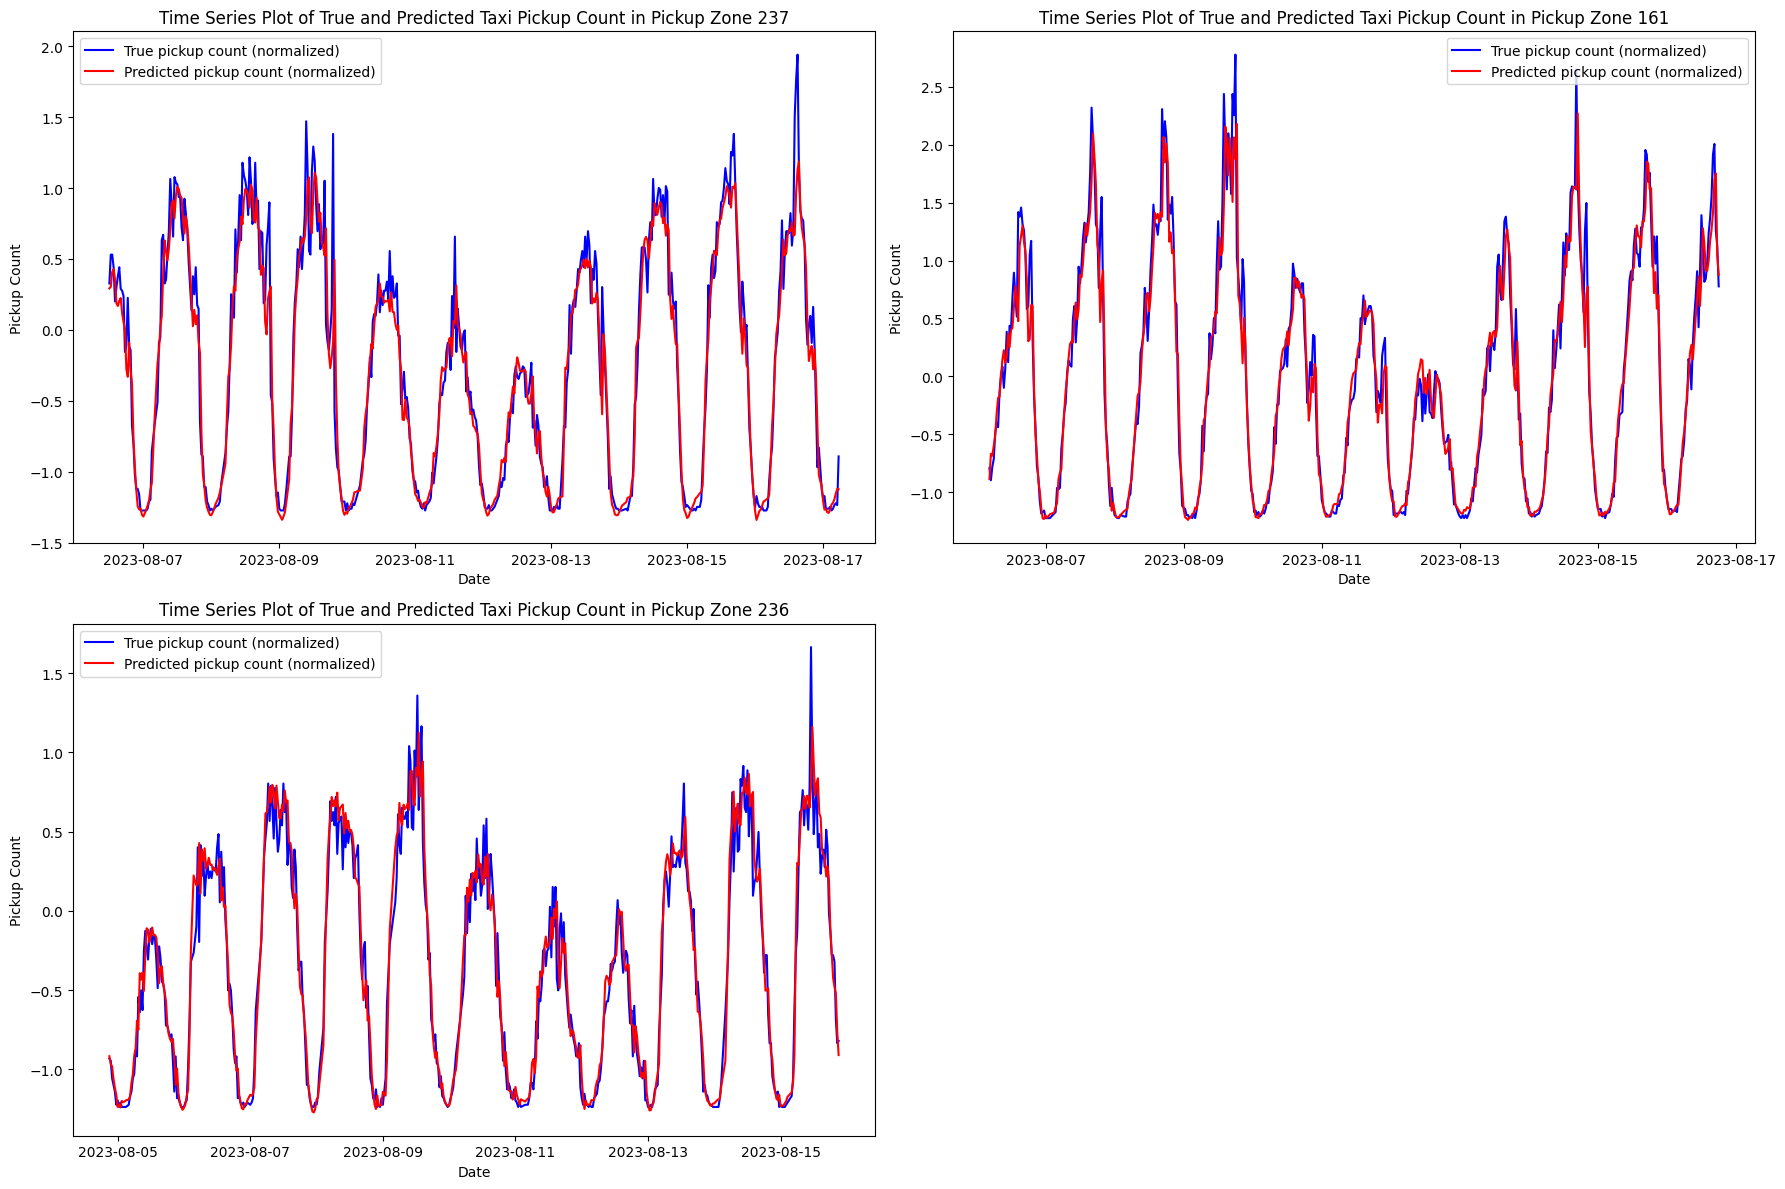

In [359]:
def visualize_time_series(Y_test, Y_test_pred, test_date, axs_idx, location):
    i, j = axs_idx[0], axs_idx[1]
    axs[i, j].plot(test_date[:500], Y_test[:500], label='True pickup count (normalized)', color='blue', linestyle='-')
    axs[i, j].plot(test_date[:500], Y_test_pred[:500], label='Predicted pickup count (normalized)', color='red', linestyle='-')
    axs[i, j].set_title(f'Time Series Plot of True and Predicted Taxi Pickup Count in Pickup Zone {location}')
    axs[i, j].set_xlabel('Date')
    axs[i, j].set_ylabel('Pickup Count')
    axs[i, j].legend()

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs_idxs = [(0, 0), (0, 1), (1, 0)]
locations = ['237', '161', '236']
for Y_test_pred, Y_test, test_date, axs_idx, location in zip(Y_test_preds, Y_tests, test_dates, axs_idxs, locations):
    Y_test_pred_shifted = Y_test_pred[:, 0]
    Y_test_shifted = Y_test[:Y_test_pred_shifted.shape[0], 0]
    print(f'Model prediction MSE = {mse(Y_test_shifted[:, jnp.newaxis], Y_test_pred_shifted[:, jnp.newaxis])}')
    visualize_time_series(Y_test_shifted, Y_test_pred_shifted, test_date, axs_idx, location)
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()